#  OpenEO Use Case 2: Multi–source phenology toolbox
Use case implemented by VITO.

## Official description
This use case concentrates on data fusion tools, time-series generation and phenological
metrics using Sentinel-2 data. It will be tested on several back-end platforms by pilot users from
the Action against Hunger and the International Centre for Integrated Mountain Development.
The here tested processes depend on the availability of orthorectified Sentinel-2 surface re-
flectance data including per pixel quality masks.

## Overview

In this use case, the goal is to derive phenology information from Sentinel-2 time series data.
In this case, phenology is defined by:
- Start of season, a date and the corresponding value of the biophysical indicator
- The maximum value of the growing curve for the indicator
- End of season, a date and the corresponding value of the biophysical indicator

Multiple biophysical indicators exist. But in this use case, the enhanced vegitation index (EVI) is used.

We start by importing the necessary packages, and defining an area of interest.
During the algorithm development phase, we work on a limited study field, so that we can use
the direct execution capabilities of OpenEO to receive feedback on the implemented changes.


In [1]:
from shapely.geometry import Polygon

from openeo import ImageCollection

import openeo
import logging
import os
from pathlib import Path
import json

#enable logging in requests library
from openeo.rest.imagecollectionclient import ImageCollectionClient



polygon = Polygon(shell= [
            [
              5.152158737182616,
              51.18469636040683
            ],
            [
              5.15183687210083,
              51.181979395425095
            ],
            [
              5.152802467346191,
              51.18192559252128
            ],
            [
              5.153381824493408,
              51.184588760878924
            ],
            [
              5.152158737182616,
              51.18469636040683
            ]
          ])

polygon = Polygon(shell=[[5.143297433853149,51.18163191723127],[5.143297433853149,51.18450357774117],[5.159090280532837,51.18450357774117],[5.159090280532837,51.18163191723127],[5.143297433853149,51.18163191723127]])

minx,miny,maxx,maxy = polygon.bounds


Connect to the OpenEO backend.


In [2]:
session = openeo.session("nobody", "http://localhost:5000/openeo/0.4.0")

#retrieve the list of available collections
collections = session.list_collections()
collections


[{'bands': [],
  'description': 'The FAPAR quantifies the fraction of the solar radiation absorbed by live leaves for the photosynthesis activity. Then, it refers only to the green and alive elements of the canopy. The FAPAR depends on the canopy structure, vegetation element optical properties, atmospheric conditions, and angular configuration. To overcome this latter dependency, a daily integrated FAPAR value is assessed.\n\nFAPAR is recognized as an Essential Climate Variable (ECV) by the Global Climate Observing System (GCOS).',
  'extent': {'crs': 'EPSG:4326',
   'spatial': [180, -56, -180, 83],
   'temporal': ['2014-01-01', None]},
  'id': 'BIOPAR_FAPAR_V1_GLOBAL',
  'license': 'free',
  'links': [{'href': 'https://land.copernicus.eu/global/products/fapar',
    'rel': 'alternate',
    'title': 'Product web page.'}],
  'name': 'BIOPAR_FAPAR_V1_GLOBAL',
  'product_id': 'BIOPAR_FAPAR_V1_GLOBAL',
  'title': 'Copernicus Global Land FAPAR product V1'},
 {'bands': [{'band_id': 'VV', 'na

Create an EVI data cube, based on reflectance bands. 
The formula for the EVI index can be expressed using plain Python.


In [3]:
s2_radiometry = session.imagecollection("CGS_SENTINEL2_RADIOMETRY_V102_001") \
                    .date_range_filter("2017-05-01","2017-10-01") \
                    .bbox_filter(left=minx,right=maxx,top=maxy,bottom=miny,srs="EPSG:4326")

B02 = s2_radiometry.band('2')
B04 = s2_radiometry.band('4')
B08 = s2_radiometry.band('8')

evi_cube: ImageCollectionClient = (2.5 * (B08 - B04)) / ((B08 + 6.0 * B04 - 7.5 * B02) + 1.0)

#write graph to json, as example
def write_graph(graph, filename):    
    with open(filename, 'w') as outfile:  
        json.dump(graph, outfile,indent=4)
write_graph(evi_cube.graph,"evi_cube.json")


Extract an unsmoothed timeseries, this allows us to evaluate the intermediate result.
For further analysis, smoothing will be needed.


In [4]:
timeseries_raw_dc = evi_cube.polygonal_mean_timeseries(polygon)
timeseries_raw = timeseries_raw_dc.execute()
timeseries_raw


{'2017-05-06T00:00:00': 3598.0524640657086,
 '2017-05-13T00:00:00': 7307.249848024316,
 '2017-05-16T00:00:00': 4092.7924991986324,
 '2017-05-23T00:00:00': nan,
 '2017-05-26T00:00:00': 3777.731946911903,
 '2017-06-02T00:00:00': 3812.196677604594,
 '2017-06-05T00:00:00': 6360.154535637149,
 '2017-06-22T00:00:00': 4539.456624282198,
 '2017-07-02T00:00:00': nan,
 '2017-07-05T00:00:00': 7335.012636720824,
 '2017-07-07T00:00:00': 3168.797873482977,
 '2017-07-10T00:00:00': 2348.649831649832,
 '2017-07-12T00:00:00': nan,
 '2017-07-17T00:00:00': 4105.536402789171,
 '2017-07-20T00:00:00': 9464.589898348158,
 '2017-07-22T00:00:00': 2643.743516761543,
 '2017-07-27T00:00:00': nan,
 '2017-07-30T00:00:00': nan,
 '2017-08-04T00:00:00': 4659.939823394746,
 '2017-08-06T00:00:00': 2695.4123957091774,
 '2017-08-09T00:00:00': 17288.5,
 '2017-08-11T00:00:00': nan,
 '2017-08-14T00:00:00': 3912.7987079573422,
 '2017-08-19T00:00:00': 9540.798393267023,
 '2017-08-21T00:00:00': 6191.4967382962395,
 '2017-08-24T0

<Figure size 504x1008 with 0 Axes>

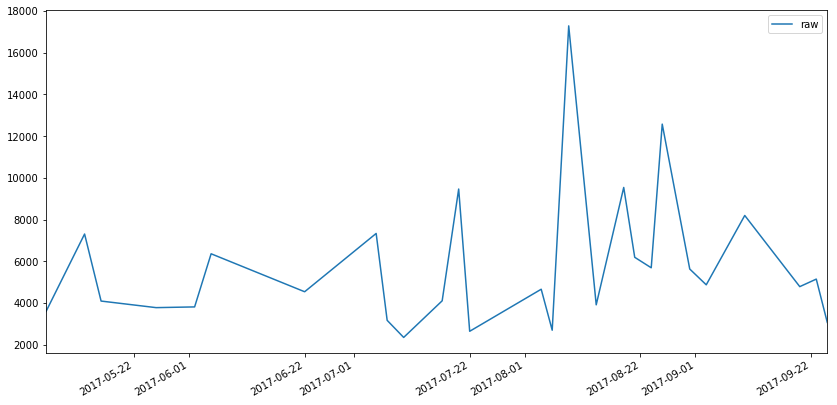

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
ts = pd.Series(timeseries_raw)
ts.name = 'raw'
all_timeseries = pd.DataFrame(ts.dropna())
all_timeseries.index = pd.to_datetime(all_timeseries.index)
fig = plt.figure(figsize=(7,14))
all_timeseries.plot(figsize=(14,7))


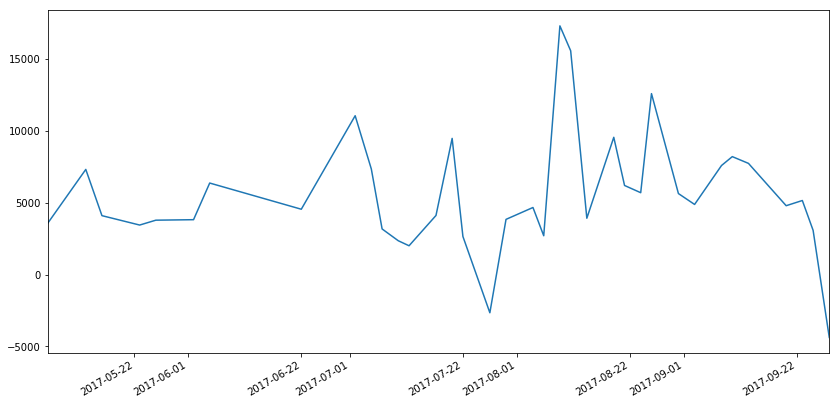

In [6]:
ts.index = pd.to_datetime(ts.index)
ts.interpolate(method='spline',order=2).plot(figsize=(14,7))


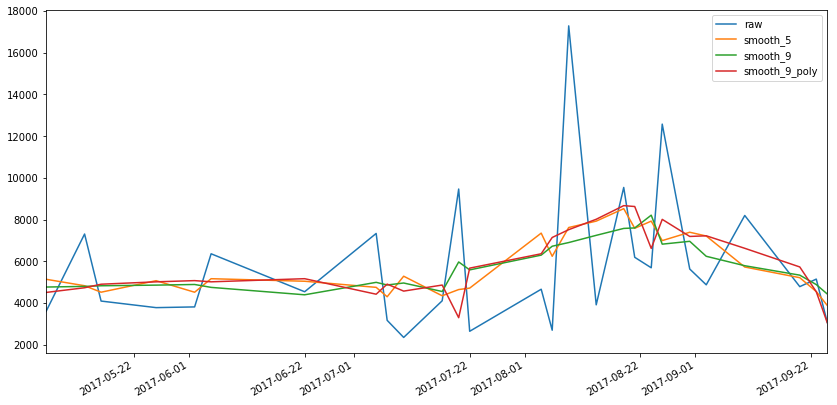

In [7]:
from scipy.signal import savgol_filter
smoothed_array = savgol_filter(all_timeseries.raw, 5, 1)
all_timeseries['smooth_5'] = smoothed_array
all_timeseries['smooth_9'] = savgol_filter(all_timeseries.raw, 9, 1)
all_timeseries['smooth_9_poly'] = savgol_filter(all_timeseries.raw, 9, 2)
all_timeseries.plot(figsize=(14,7))


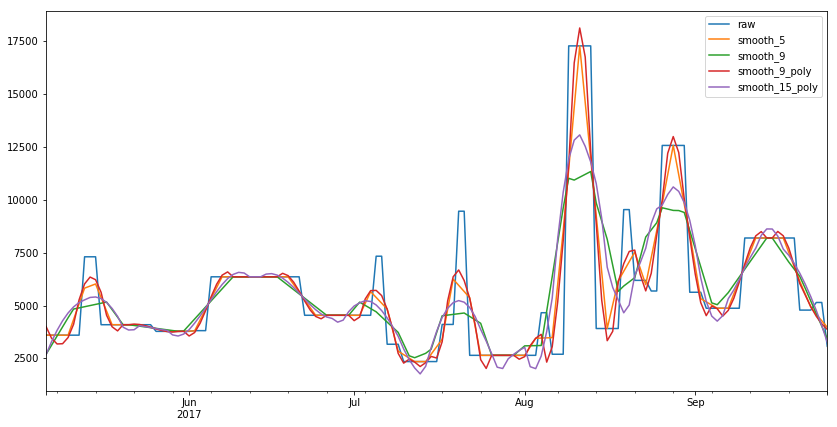

In [8]:

filled_df = pd.DataFrame(all_timeseries.raw.asfreq('D',method='pad'))
filled_df['smooth_5'] = savgol_filter(filled_df.raw, 5, 1)
filled_df['smooth_9'] = savgol_filter(filled_df.raw, 9, 1)
filled_df['smooth_9_poly'] = savgol_filter(filled_df.raw, 9, 2)
filled_df['smooth_15_poly'] = savgol_filter(filled_df.raw, 15, 2)

filled_df.plot(figsize=(14,7))



In [10]:
def get_resource(relative_path):
    
    return str(Path( relative_path))
def load_udf(relative_path):
    import json
    with open(get_resource(relative_path), 'r+') as f:
        return f.read()

smoothing_udf = load_udf('udf/smooth_savitzky_golay.py')
#S2 radiometry at VITO already has a default mask otherwise we need a masking function
smoothed_evi = evi_cube.apply_dimension(smoothing_udf,runtime='Python')
timeseries_smooth = smoothed_evi.polygonal_mean_timeseries(polygon)

write_graph(timeseries_smooth.graph,"timeseries_udf.json")
ts_savgol = pd.Series(timeseries_smooth.execute())
ts_savgol.head(10)

2017-05-06T00:00:00    4834.586465
2017-05-13T00:00:00    4606.899439
2017-05-16T00:00:00    4379.212413
2017-05-23T00:00:00    4421.283604
2017-05-26T00:00:00    4360.997338
2017-06-02T00:00:00    4455.174142
2017-06-05T00:00:00    4845.865049
2017-06-22T00:00:00    5533.070057
2017-07-02T00:00:00    5417.303630
2017-07-05T00:00:00    4647.120563
dtype: float64

In [18]:
ts_savgol.dropna(inplace=True)
ts_savgol.index = pd.to_datetime(ts_savgol.index)
ts_savgol.head(10)

2017-05-06    4834.586465
2017-05-13    4606.899439
2017-05-16    4379.212413
2017-05-23    4421.283604
2017-05-26    4360.997338
2017-06-02    4455.174142
2017-06-05    4845.865049
2017-06-22    5533.070057
2017-07-02    5417.303630
2017-07-05    4647.120563
dtype: float64

,raw,savgol_udf
2017-05-06,3598.052464,4834.586465
2017-05-13,7307.249848,4606.899439
2017-05-16,4092.792499,4379.212413
2017-05-26,3777.731947,4360.997338
2017-06-02,3812.196678,4455.174142


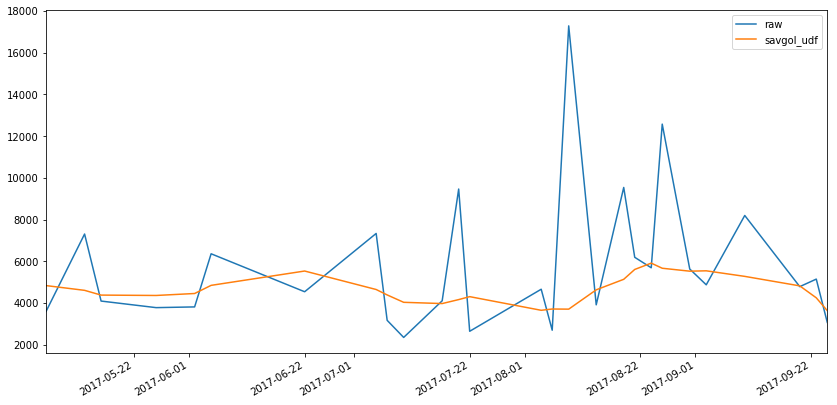

In [16]:
all_timeseries['savgol_udf'] =ts_savgol 
all_timeseries.plot(figsize=(14,7))
all_timeseries.head()



In [138]:
import numpy as np
a = np.asarray([[1,2,3],[4,np.nan,6],[7,8,9],[1,2,3]])
a.shape
pd.DataFrame(a).interpolate()


,0,1,2
0,1.0,2.0,3.0
1,4.0,5.0,6.0
2,7.0,8.0,9.0
3,1.0,2.0,3.0


In [30]:
!pwd


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
/home/driesj/pythonworkspace/openeo-client-api/examples/notebooks
